##  Notebook 06 de 06


(Versão, 14 de Abril de 2025)




# Detecção de Desbalanceamento em Máquinas Rotativas por meio da Análise de Sinais de Vibração utilizando Deep Learning

**Notebook usado como Referência:**

Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt. "Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data". 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020.



In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Abordagem 6: CNN - Convolutional Neural Network como Regressor - 4 Classes

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.preprocessing import RobustScaler
import seaborn as sn

## Reading Measurement Data and Preprocessing

In [3]:
# Option a) local file contains a small subset of the entire dataset
url = '/content/gdrive/MyDrive/Base de Dados/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option c) selected pre-trained models can be found in the directory model/reference
use_reference_models = False
model_path = '../models/reference'

# Option d) all models will be trained again
#use_reference_models = False
#model_path = '../models'

In [4]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

**PRÉ-TRATAMENTO DOS SINAIS**

Separação das duas sequências de aquisição de dados

In [5]:
data0D_A = data0D.iloc[0:int(len(data0D)/2)]
data0D_B = data0D.iloc[int(len(data0D)/2):]
data0E_A = data0E.iloc[0:int(len(data0E)/2)]
data0E_B = data0E.iloc[int(len(data0E)/2):]
data1D_A = data1D.iloc[0:int(len(data1D)/2)]
data1D_B = data1D.iloc[int(len(data1D)/2):]
data1E_A = data1E.iloc[0:int(len(data1E)/2)]
data1E_B = data1E.iloc[int(len(data1E)/2):]
data2D_A = data2D.iloc[0:int(len(data2D)/2)]
data2D_B = data2D.iloc[int(len(data2D)/2):]
data2E_A = data2E.iloc[0:int(len(data2E)/2)]
data2E_B = data2E.iloc[int(len(data2E)/2):]
data3D_A = data3D.iloc[0:int(len(data3D)/2)]
data3D_B = data3D.iloc[int(len(data3D)/2):]
data3E_A = data3E.iloc[0:int(len(data3E)/2)]
data3E_B = data3E.iloc[int(len(data3E)/2):]
data4D_A = data4D.iloc[0:int(len(data4D)/2)]
data4D_B = data4D.iloc[int(len(data4D)/2):]
data4E_A = data4E.iloc[0:int(len(data4E)/2)]
data4E_B = data4E.iloc[int(len(data4E)/2):]

Descarte das amostras iniciais e finais

In [6]:
skip = 100000
data0D_A = data0D_A.iloc[skip:-skip,:]
data0D_B = data0D_B.iloc[skip:-skip,:]
data0E_A = data0E_A.iloc[skip:-skip,:]
data0E_B = data0E_B.iloc[skip:-skip,:]
data1D_A = data1D_A.iloc[skip:-skip,:]
data1D_B = data1D_B.iloc[skip:-skip,:]
data1E_A = data1E_A.iloc[skip:-skip,:]
data1E_B = data1E_B.iloc[skip:-skip,:]
data2D_A = data2D_A.iloc[skip:-skip,:]
data2D_B = data2D_B.iloc[skip:-skip,:]
data2E_A = data2E_A.iloc[skip:-skip,:]
data2E_B = data2E_B.iloc[skip:-skip,:]
data3D_A = data3D_A.iloc[skip:-skip,:]
data3D_B = data3D_B.iloc[skip:-skip,:]
data3E_A = data3E_A.iloc[skip:-skip,:]
data3E_B = data3E_B.iloc[skip:-skip,:]
data4D_A = data4D_A.iloc[skip:-skip,:]
data4D_B = data4D_B.iloc[skip:-skip,:]
data4E_A = data4E_A.iloc[skip:-skip,:]
data4E_B = data4E_B.iloc[skip:-skip,:]

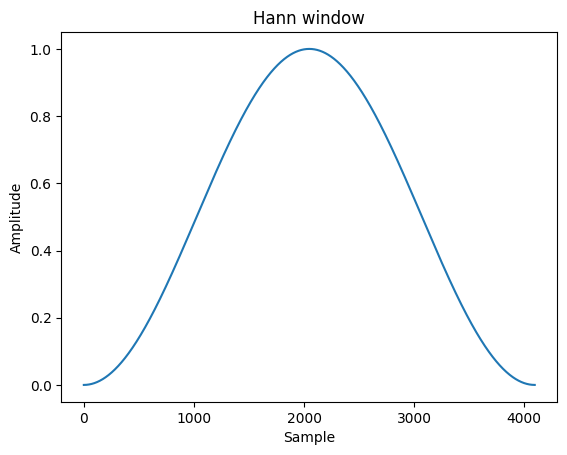

In [7]:
window = np.hanning(4096)
plt.plot(window)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.show()

Normalização pelo quadrado da velocidade

In [8]:
def normaliza_vibracao(basededados, sensor, quad=True):
  if quad:
    basededados[sensor] = basededados[sensor]/np.square(basededados['Measured_RPM'])
  else:
    basededados[sensor] = basededados[sensor]/basededados['Measured_RPM']
  return basededados

Função para segmentar a série temporal

In [9]:
labels = {'Balanced' : 0.0, 'Unbalanced_LowLow' : 45.9, 'Unbalanced_Low': 60.7, 'Unbalanced_High': 75.5, 'Unbalanced_HighHigh': 152.1}

samples_per_second = 4096
seconds_per_analysis = 1.0
window = int(samples_per_second*seconds_per_analysis)

def get_features(data, label):
    n = int(np.floor(len(data)/window))
    data = data[:int(n)*window]
    X = data.values.reshape((n, window))
    y = np.ones(n)*labels[label]
    return X,y

Dividindo a série temporal dos dados do sensor **"Vibration_1"** em segmentos de  comprimento 4096

In [33]:
sensor = 'Vibration_1'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
#X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
#X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
#X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
#X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
#X1 = np.concatenate([X1_A, X1_B])
#y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
#X1_val = np.concatenate([X1_A_val, X1_B_val])
#y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_1=np.concatenate([X0, X2, X3, X4])
y=np.concatenate([y0, y2, y3, y4])

X_Vibration_1_val=np.concatenate([X0_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y2_val, y3_val, y4_val])

Dividindo a série temporal dos dados do sensor **"Vibration_2"** em segmentos de  comprimento 4096

In [19]:
sensor = 'Vibration_2'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_2=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_2_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Dividindo a série temporal dos dados do sensor **"Vibration_3"** em segmentos de  comprimento 4096

In [12]:
sensor = 'Vibration_3'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Vibration_3=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Vibration_3_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

Dividindo a série temporal dos dados do sensor **"Measured_RPM"** em segmentos de  comprimento 4096

In [13]:
sensor = 'Measured_RPM'

X0_A,y0_A = get_features(data0D_A[sensor], 'Balanced')
X1_A,y1_A = get_features(data1D_A[sensor], 'Unbalanced_LowLow')
X2_A,y2_A = get_features(data2D_A[sensor], 'Unbalanced_Low')
X3_A,y3_A = get_features(data3D_A[sensor], 'Unbalanced_High')
X4_A,y4_A = get_features(data4D_A[sensor], 'Unbalanced_HighHigh')


X0_A_val, y0_A_val = get_features(data0E_A[sensor], 'Balanced')
X1_A_val, y1_A_val = get_features(data1E_A[sensor], 'Unbalanced_LowLow')
X2_A_val, y2_A_val = get_features(data2E_A[sensor], 'Unbalanced_Low')
X3_A_val, y3_A_val = get_features(data3E_A[sensor], 'Unbalanced_High')
X4_A_val, y4_A_val = get_features(data4E_A[sensor], 'Unbalanced_HighHigh')


X0_B,y0_B = get_features(data0D_B[sensor], 'Balanced')
X1_B,y1_B = get_features(data1D_B[sensor], 'Unbalanced_LowLow')
X2_B,y2_B = get_features(data2D_B[sensor], 'Unbalanced_Low')
X3_B,y3_B = get_features(data3D_B[sensor], 'Unbalanced_High')
X4_B,y4_B = get_features(data4D_B[sensor], 'Unbalanced_HighHigh')


X0_B_val, y0_B_val = get_features(data0E_B[sensor], 'Balanced')
X1_B_val, y1_B_val = get_features(data1E_B[sensor], 'Unbalanced_LowLow')
X2_B_val, y2_B_val = get_features(data2E_B[sensor], 'Unbalanced_Low')
X3_B_val, y3_B_val = get_features(data3E_B[sensor], 'Unbalanced_High')
X4_B_val, y4_B_val = get_features(data4E_B[sensor], 'Unbalanced_HighHigh')

X0 = np.concatenate([X0_A, X0_B])
y0 = np.concatenate([y0_A, y0_B])
X1 = np.concatenate([X1_A, X1_B])
y1 = np.concatenate([y1_A, y1_B])
X2 = np.concatenate([X2_A, X2_B])
y2 = np.concatenate([y2_A, y2_B])
X3 = np.concatenate([X3_A, X3_B])
y3 = np.concatenate([y3_A, y3_B])
X4 = np.concatenate([X4_A, X4_B])
y4 = np.concatenate([y4_A, y4_B])

X0_val = np.concatenate([X0_A_val, X0_B_val])
y0_val = np.concatenate([y0_A_val, y0_B_val])
X1_val = np.concatenate([X1_A_val, X1_B_val])
y1_val = np.concatenate([y1_A_val, y1_B_val])
X2_val = np.concatenate([X2_A_val, X2_B_val])
y2_val = np.concatenate([y2_A_val, y2_B_val])
X3_val = np.concatenate([X3_A_val, X3_B_val])
y3_val = np.concatenate([y3_A_val, y3_B_val])
X4_val = np.concatenate([X4_A_val, X4_B_val])
y4_val = np.concatenate([y4_A_val, y4_B_val])


X_Measured_RPM=np.concatenate([X0, X1, X2, X3, X4])
y=np.concatenate([y0, y1, y2, y3, y4])

X_Measured_RPM_val=np.concatenate([X0_val, X1_val, X2_val, X3_val, X4_val])
y_val=np.concatenate([y0_val, y1_val, y2_val, y3_val, y4_val])

In [34]:
print(X_Vibration_1.shape, y.shape, X_Vibration_1_val.shape, y_val.shape)

(25388, 4096) (25388,) (6344, 4096) (6344,)


In [21]:
print(X_Vibration_2.shape, y.shape, X_Vibration_2_val.shape, y_val.shape)

(31736, 4096) (31736,) (7932, 4096) (7932,)


In [22]:
print(X_Vibration_3.shape, y.shape, X_Vibration_3_val.shape, y_val.shape)

(31736, 4096) (31736,) (7932, 4096) (7932,)


In [23]:
print(X_Measured_RPM.shape, y.shape, X_Measured_RPM_val.shape, y_val.shape)

(31736, 4096) (31736,) (7932, 4096) (7932,)


**Janelamento dos sinais de vibração** (Posicionado aqui para não gerar estouro de RAM)

In [35]:
def janelamentoHanning(basededados, window):
  janela_hanning = np.hanning(window)
  basededados = basededados*janela_hanning
  return basededados

In [36]:
X_Vibration_1_jan = janelamentoHanning(X_Vibration_1, 4096)
X_Vibration_1_val_jan = janelamentoHanning(X_Vibration_1_val, 4096)
X_Vibration_2_jan = janelamentoHanning(X_Vibration_2, 4096)
X_Vibration_2_val_jan = janelamentoHanning(X_Vibration_2_val, 4096)
X_Vibration_3_jan = janelamentoHanning(X_Vibration_3, 4096)
X_Vibration_3_val_jan = janelamentoHanning(X_Vibration_3_val, 4096)

In [37]:
X_Vibration_1_jan.shape

(25388, 4096)

Calculando as estatísticas da velocidade

In [38]:
X_Measured_RPM_mean = np.mean(X_Measured_RPM, axis=1)
X_Measured_RPM_mean = X_Measured_RPM_mean.reshape(X_Measured_RPM_mean.shape[0],1)
X_Measured_RPM_val_mean = np.mean(X_Measured_RPM_val, axis=1)
X_Measured_RPM_val_mean = X_Measured_RPM_val_mean.reshape(X_Measured_RPM_val_mean.shape[0],1)

In [39]:
X_Measured_RPM_mean.shape

(31736, 1)

**Função para cálculo da FFT**

In [40]:
def calcula_fft(basededados, window, freq_inicio, freq_fim):
  X_fft = np.abs(np.fft.rfft(basededados, axis=1))[:,:int(window/2)]
  return X_fft[:, freq_inicio:freq_fim]

**Extrair o Módulo da FFT do sinal**

In [41]:
freq_inicio = 0 #Hz
freq_fim = 4096 #Hz

X_Vibration_1_fft = calcula_fft(X_Vibration_1_jan, 4096, freq_inicio, freq_fim)
X_Vibration_1_val_fft = calcula_fft(X_Vibration_1_val_jan, 4096, freq_inicio, freq_fim)
X_Vibration_2_fft = calcula_fft(X_Vibration_2_jan, 4096, freq_inicio, freq_fim)
X_Vibration_2_val_fft = calcula_fft(X_Vibration_2_val_jan, 4096, freq_inicio, freq_fim)
X_Vibration_3_fft = calcula_fft(X_Vibration_3_jan, 4096, freq_inicio, freq_fim)
X_Vibration_3_val_fft = calcula_fft(X_Vibration_3_val_jan, 4096, freq_inicio, freq_fim)

## **Encaixar no código**

Definir quais sinais serão utilizados de entrada para o modelo de Machine Learning

In [ ]:
#X = np.concatenate(( X_Measured_RPM_mean, X_Vibration_1_fft), axis=1) # X_Vibration_2_fft, X_Vibration_3_fft, X_Measured_RPM_mean), axis=1)
#X_val = np.concatenate((X_Measured_RPM_val_mean, X_Vibration_1_val_fft), axis=1) # X_Vibration_2_val_fft, X_Vibration_3_val_fft, X_Measured_RPM_val_mean), axis=1)

In [42]:
X = X_Vibration_1_fft
X_val = X_Vibration_1_val_fft

## Train-Test-Split

The dataset for training (X,y) is splitted into two subsets (X_train,y_train) and (X_test,y_test).

In [43]:
from sklearn.model_selection import train_test_split
train_test_ratio = 0.9
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 1-train_test_ratio, random_state = 0)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(28562, 2048, 1) (28562,) (3174, 2048, 1) (3174,) (7932, 2048, 1) (7932,)


**Escalonamento**

In [44]:
scaler = RobustScaler(quantile_range=(5,95)).fit(X_train[:,:,0])
X_train = scaler.transform(X_train[:,:,0])
X_test = scaler.transform(X_test[:,:,0])
X_val = scaler.transform(X_val[:,:,0])

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(28562, 2048) (28562,) (3174, 2048) (3174,) (7932, 2048) (7932,)


## Convolutional Neural Net (CNN)

## Test with Different Layer Numbers

In [45]:
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Dense,Dropout
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Flatten,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

def train_models(n_conv_layers):
    #n_conv_layers = 3 # [1,2,3,4]
    n_dense_units = 1028
    dropout_rate = 0.0
    use_batch_normalization = True # [True, False]
    filter_size = 5 # [5,7,9]
    learning_rate = 0.0001
    n_epochs = 100 # [50,100,200]

    X_in = Input(shape=(X_train.shape[1],1))
    x = X_in
    for j in range(n_conv_layers):
        print(j)
        x = Conv1D(filters=(j+1)*20,
                   kernel_size=filter_size,
                   strides=1,
                   activation='linear',
                   kernel_initializer='he_uniform')(x)
        if use_batch_normalization:
            x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.05)(x)
        x = MaxPooling1D(pool_size=5, strides=2)(x)
    x = Flatten()(x)
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #segunda camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #terceira camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #quarta camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    #quinta camada Densa
    x = Dense(units = n_dense_units, activation='linear')(x)
    x = ReLU()(x)
    x = Dropout(rate=dropout_rate)(x)
    X_out = Dense(units = 1, activation = 'linear')(x)
    classifier = Model(X_in, X_out)
    classifier.summary()

    best_model_filepath = f"{model_path}/cnn_{n_conv_layers}_layers.h5"
    checkpoint = ModelCheckpoint(best_model_filepath, monitor='val_loss',
                                 verbose=1, save_best_only=True, mode='min')

    classifier.compile(optimizer = Adam(learning_rate=learning_rate), loss = 'mean_absolute_error',
                       metrics = ['MeanAbsoluteError'])

    history = classifier.fit(X_train, y_train, epochs = n_epochs, batch_size = 64,
                   validation_data=(X_test, y_test), callbacks=[checkpoint])

    classifier = load_model(best_model_filepath)
    score = classifier.evaluate(X_val, y_val)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

In [46]:
nMaxConvLayers = 5

0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1028)           │    20,972,228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,204,705 (96.15 MB)

 Trainable params: 25,204,665 (96.15 MB)

 Non-trainable params: 40 (160.00 B)

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - MeanAbsoluteError: 24.0987 - loss: 24.0987
Epoch 1: val_loss improved from inf to 9.92135, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - MeanAbsoluteError: 24.0725 - loss: 24.0725 - val_MeanAbsoluteError: 9.9214 - val_loss: 9.9214
Epoch 2/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 8.2476 - loss: 8.2476
Epoch 2: val_loss did not improve from 9.92135
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 8.2456 - loss: 8.2456 - val_MeanAbsoluteError: 17.5409 - val_loss: 17.5409
Epoch 3/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 9.2413 - loss: 9.2413
Epoch 3: val_loss improved from 9.92135 to 9.03722, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 9.2319 - loss: 9.2319 - val_MeanAbsoluteError: 9.0372 - val_loss: 9.0372
Epoch 4/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 7.3688 - loss: 7.3688
Epoch 4: val_loss did not improve from 9.03722
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 7.3685 - loss: 7.3685 - val_MeanAbsoluteError: 15.8125 - val_loss: 15.8125
Epoch 5/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 8.0123 - loss: 8.0123
Epoch 5: val_loss did not improve from 9.03722
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 8.0024 - loss: 8.0024 - val_MeanAbsoluteError: 12.5460 - val_loss: 12.5460
Epoch 6/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 6.7112 - loss: 6.7112
Epoch 6: val_loss did not improve from 9.03722
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 6.7086 - loss: 6.7086 - val_MeanAbsoluteError: 12.3087 - val_loss: 12.3087
Epoch 7/100
355/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 7.5808 - loss: 7.5808 - val_MeanAbsoluteError: 8.1976 - val_loss: 8.1976
Epoch 8/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.6954 - loss: 5.6954
Epoch 8: val_loss did not improve from 8.19761
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 5.7022 - loss: 5.7022 - val_MeanAbsoluteError: 10.2451 - val_loss: 10.2451
Epoch 9/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 6.1041 - loss: 6.1041
Epoch 9: val_loss did not improve from 8.19761
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 6.1043 - loss: 6.1043 - val_MeanAbsoluteError: 9.1471 - val_loss: 9.1471
Epoch 10/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 6.2543 - loss: 6.2543
Epoch 10: val_loss improved from 8.19761 to 4.27213, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 6.2493 - loss: 6.2493 - val_MeanAbsoluteError: 4.2721 - val_loss: 4.2721
Epoch 11/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 4.8990 - loss: 4.8990
Epoch 11: val_loss improved from 4.27213 to 2.91662, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 4.9015 - loss: 4.9015 - val_MeanAbsoluteError: 2.9166 - val_loss: 2.9166
Epoch 12/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.7051 - loss: 5.7051
Epoch 12: val_loss did not improve from 2.91662
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 5.7029 - loss: 5.7029 - val_MeanAbsoluteError: 3.8727 - val_loss: 3.8727
Epoch 13/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.9313 - loss: 5.9313
Epoch 13: val_loss did not improve from 2.91662
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 5.9285 - loss: 5.9285 - val_MeanAbsoluteError: 2.9918 - val_loss: 2.9918
Epoch 14/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.3898 - loss: 5.3898
Epoch 14: val_loss improved from 2.91662 to 2.63157, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 5.3873 - loss: 5.3873 - val_MeanAbsoluteError: 2.6316 - val_loss: 2.6316
Epoch 15/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.0256 - loss: 5.0256
Epoch 15: val_loss did not improve from 2.63157
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 5.0269 - loss: 5.0269 - val_MeanAbsoluteError: 4.6144 - val_loss: 4.6144
Epoch 16/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 6.4099 - loss: 6.4099
Epoch 16: val_loss did not improve from 2.63157
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 6.4034 - loss: 6.4034 - val_MeanAbsoluteError: 2.8618 - val_loss: 2.8618
Epoch 17/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 4.6464 - loss: 4.6464
Epoch 17: val_loss improved from 2.63157 to 2.36353, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 4.6479 - loss: 4.6479 - val_MeanAbsoluteError: 2.3635 - val_loss: 2.3635
Epoch 18/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.6260 - loss: 5.6260
Epoch 18: val_loss improved from 2.36353 to 2.08030, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 5.6242 - loss: 5.6242 - val_MeanAbsoluteError: 2.0803 - val_loss: 2.0803
Epoch 19/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.4486 - loss: 5.4486
Epoch 19: val_loss did not improve from 2.08030
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 5.4476 - loss: 5.4476 - val_MeanAbsoluteError: 4.4861 - val_loss: 4.4861
Epoch 20/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 4.9589 - loss: 4.9589
Epoch 20: val_loss did not improve from 2.08030
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 4.9541 - loss: 4.9541 - val_MeanAbsoluteError: 2.3749 - val_loss: 2.3749
Epoch 21/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.2363 - loss: 5.2363
Epoch 21: val_loss did not improve from 2.08030
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 5.2349 - loss: 5.2349 - val_MeanAbsoluteError: 2.4536 - val_loss: 2.4536
Epoch 22/100
358/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 3.8382 - loss: 3.8382 - val_MeanAbsoluteError: 2.0308 - val_loss: 2.0308
Epoch 39/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.3256 - loss: 4.3256
Epoch 39: val_loss improved from 2.03079 to 1.91579, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 4.3250 - loss: 4.3250 - val_MeanAbsoluteError: 1.9158 - val_loss: 1.9158
Epoch 40/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.8648 - loss: 3.8648
Epoch 40: val_loss improved from 1.91579 to 1.75173, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 3.8676 - loss: 3.8676 - val_MeanAbsoluteError: 1.7517 - val_loss: 1.7517
Epoch 41/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.7263 - loss: 3.7263
Epoch 41: val_loss did not improve from 1.75173
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 3.7265 - loss: 3.7265 - val_MeanAbsoluteError: 2.0297 - val_loss: 2.0297
Epoch 42/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.5633 - loss: 3.5633
Epoch 42: val_loss did not improve from 1.75173
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 3.5648 - loss: 3.5648 - val_MeanAbsoluteError: 3.7996 - val_loss: 3.7996
Epoch 43/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.6872 - loss: 3.6872
Epoch 43: val_loss improved from 1.75173 to 1.48402, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 3.6870 - loss: 3.6870 - val_MeanAbsoluteError: 1.4840 - val_loss: 1.4840
Epoch 44/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.6666 - loss: 3.6666
Epoch 44: val_loss did not improve from 1.48402
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 3.6665 - loss: 3.6665 - val_MeanAbsoluteError: 2.4811 - val_loss: 2.4811
Epoch 45/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.8503 - loss: 3.8503
Epoch 45: val_loss did not improve from 1.48402
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 3.8504 - loss: 3.8504 - val_MeanAbsoluteError: 4.2428 - val_loss: 4.2428
Epoch 46/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.4682 - loss: 3.4682
Epoch 46: val_loss did not improve from 1.48402
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 3.4674 - loss: 3.4674 - val_MeanAbsoluteError: 4.0128 - val_loss: 4.0128
Epoch 47/100
356/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.1855 - loss: 2.1855 - val_MeanAbsoluteError: 1.4181 - val_loss: 1.4181
Epoch 77/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.0928 - loss: 2.0928
Epoch 77: val_loss did not improve from 1.41814
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.0928 - loss: 2.0928 - val_MeanAbsoluteError: 1.9117 - val_loss: 1.9117
Epoch 78/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.2705 - loss: 2.2705
Epoch 78: val_loss did not improve from 1.41814
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.2705 - loss: 2.2705 - val_MeanAbsoluteError: 4.4809 - val_loss: 4.4809
Epoch 79/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.2139 - loss: 2.2139
Epoch 79: val_loss did not improve from 1.41814
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.2141 - loss: 2.2141 - val_MeanAbsoluteError: 2.9011 - val_loss: 2.9011
Epoch 80/100
352/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.2410 - loss: 2.2410 - val_MeanAbsoluteError: 1.2899 - val_loss: 1.2899
Epoch 85/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.2666 - loss: 2.2666
Epoch 85: val_loss improved from 1.28994 to 1.27800, saving model to ../models/reference/cnn_1_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.2666 - loss: 2.2666 - val_MeanAbsoluteError: 1.2780 - val_loss: 1.2780
Epoch 86/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.1483 - loss: 2.1483
Epoch 86: val_loss did not improve from 1.27800
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.1481 - loss: 2.1481 - val_MeanAbsoluteError: 1.6199 - val_loss: 1.6199
Epoch 87/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.5264 - loss: 2.5264
Epoch 87: val_loss did not improve from 1.27800
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.5228 - loss: 2.5228 - val_MeanAbsoluteError: 3.6028 - val_loss: 3.6028
Epoch 88/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.5249 - loss: 2.5249
Epoch 88: val_loss did not improve from 1.27800
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.5235 - loss: 2.5235 - val_MeanAbsoluteError: 1.3996 - val_loss: 1.3996
Epoch 89/100
353/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.9168 - loss: 1.9168 - val_MeanAbsoluteError: 1.2583 - val_loss: 1.2583
Epoch 91/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.8720 - loss: 1.8720
Epoch 91: val_loss did not improve from 1.25833
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.8735 - loss: 1.8735 - val_MeanAbsoluteError: 3.3301 - val_loss: 3.3301
Epoch 92/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.0930 - loss: 2.0930
Epoch 92: val_loss did not improve from 1.25833
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.0928 - loss: 2.0928 - val_MeanAbsoluteError: 1.5572 - val_loss: 1.5572
Epoch 93/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.0892 - loss: 2.0892
Epoch 93: val_loss did not improve from 1.25833
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.0888 - loss: 2.0888 - val_MeanAbsoluteError: 2.5061 - val_loss: 2.5061
Epoch 94/100
355/358 ━━━

199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.8999 - mean_absolute_error: 1.8999


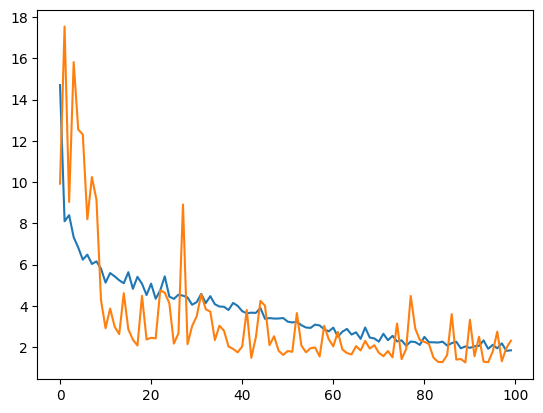

0
1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1016, 40)       │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1016, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 1016, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 506, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1028)           │    20,807,748 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 1028)           │             

 Total params: 25,044,425 (95.54 MB)

 Trainable params: 25,044,305 (95.54 MB)

 Non-trainable params: 120 (480.00 B)

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - MeanAbsoluteError: 24.5564 - loss: 24.5564
Epoch 1: val_loss improved from inf to 11.81721, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - MeanAbsoluteError: 24.5311 - loss: 24.5311 - val_MeanAbsoluteError: 11.8172 - val_loss: 11.8172
Epoch 2/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 8.8555 - loss: 8.8555
Epoch 2: val_loss improved from 11.81721 to 11.57323, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 8.8538 - loss: 8.8538 - val_MeanAbsoluteError: 11.5732 - val_loss: 11.5732
Epoch 3/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 7.8917 - loss: 7.8917
Epoch 3: val_loss improved from 11.57323 to 8.09296, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 7.8889 - loss: 7.8889 - val_MeanAbsoluteError: 8.0930 - val_loss: 8.0930
Epoch 4/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 6.4273 - loss: 6.4273
Epoch 4: val_loss did not improve from 8.09296
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 6.4233 - loss: 6.4233 - val_MeanAbsoluteError: 9.0025 - val_loss: 9.0025
Epoch 5/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 5.5566 - loss: 5.5566
Epoch 5: val_loss improved from 8.09296 to 5.80577, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 5.5543 - loss: 5.5543 - val_MeanAbsoluteError: 5.8058 - val_loss: 5.8058
Epoch 6/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.7429 - loss: 4.7429
Epoch 6: val_loss improved from 5.80577 to 5.66186, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 4.7369 - loss: 4.7369 - val_MeanAbsoluteError: 5.6619 - val_loss: 5.6619
Epoch 7/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 4.0330 - loss: 4.0330
Epoch 7: val_loss improved from 5.66186 to 2.01259, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 4.0297 - loss: 4.0297 - val_MeanAbsoluteError: 2.0126 - val_loss: 2.0126
Epoch 8/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 3.0242 - loss: 3.0242
Epoch 8: val_loss did not improve from 2.01259
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 3.0217 - loss: 3.0217 - val_MeanAbsoluteError: 4.1230 - val_loss: 4.1230
Epoch 9/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.8034 - loss: 2.8034
Epoch 9: val_loss did not improve from 2.01259
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.8040 - loss: 2.8040 - val_MeanAbsoluteError: 2.1509 - val_loss: 2.1509
Epoch 10/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.5328 - loss: 2.5328
Epoch 10: val_loss did not improve from 2.01259
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.5324 - loss: 2.5324 - val_MeanAbsoluteError: 2.3015 - val_loss: 2.3015
Epoch 11/100
355/358 ━━━━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 2.3259 - loss: 2.3259 - val_MeanAbsoluteError: 2.0047 - val_loss: 2.0047
Epoch 14/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.2457 - loss: 2.2457
Epoch 14: val_loss did not improve from 2.00471
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.2454 - loss: 2.2454 - val_MeanAbsoluteError: 4.3856 - val_loss: 4.3856
Epoch 15/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.2116 - loss: 2.2116
Epoch 15: val_loss did not improve from 2.00471
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.2077 - loss: 2.2077 - val_MeanAbsoluteError: 3.8260 - val_loss: 3.8260
Epoch 16/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.4940 - loss: 2.4940
Epoch 16: val_loss improved from 2.00471 to 1.60202, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 2.4898 - loss: 2.4898 - val_MeanAbsoluteError: 1.6020 - val_loss: 1.6020
Epoch 17/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.9128 - loss: 1.9128
Epoch 17: val_loss did not improve from 1.60202
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.9129 - loss: 1.9129 - val_MeanAbsoluteError: 3.4910 - val_loss: 3.4910
Epoch 18/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.4835 - loss: 2.4835
Epoch 18: val_loss did not improve from 1.60202
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.4787 - loss: 2.4787 - val_MeanAbsoluteError: 5.9198 - val_loss: 5.9198
Epoch 19/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 2.3697 - loss: 2.3697
Epoch 19: val_loss improved from 1.60202 to 1.50819, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 2.3644 - loss: 2.3644 - val_MeanAbsoluteError: 1.5082 - val_loss: 1.5082
Epoch 20/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.7119 - loss: 1.7119
Epoch 20: val_loss did not improve from 1.50819
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.7118 - loss: 1.7118 - val_MeanAbsoluteError: 1.7105 - val_loss: 1.7105
Epoch 21/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.7308 - loss: 1.7308
Epoch 21: val_loss did not improve from 1.50819
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.7305 - loss: 1.7305 - val_MeanAbsoluteError: 1.9131 - val_loss: 1.9131
Epoch 22/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.8402 - loss: 1.8402
Epoch 22: val_loss improved from 1.50819 to 1.26096, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.8382 - loss: 1.8382 - val_MeanAbsoluteError: 1.2610 - val_loss: 1.2610
Epoch 23/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.7019 - loss: 1.7019
Epoch 23: val_loss did not improve from 1.26096
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.7011 - loss: 1.7011 - val_MeanAbsoluteError: 3.0115 - val_loss: 3.0115
Epoch 24/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.6243 - loss: 1.6243
Epoch 24: val_loss did not improve from 1.26096
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.6236 - loss: 1.6236 - val_MeanAbsoluteError: 1.6220 - val_loss: 1.6220
Epoch 25/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.8926 - loss: 1.8926
Epoch 25: val_loss did not improve from 1.26096
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.8906 - loss: 1.8906 - val_MeanAbsoluteError: 6.1885 - val_loss: 6.1885
Epoch 26/100
355/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.4379 - loss: 1.4379 - val_MeanAbsoluteError: 1.2510 - val_loss: 1.2510
Epoch 34/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.5051 - loss: 1.5051
Epoch 34: val_loss did not improve from 1.25098
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.5035 - loss: 1.5035 - val_MeanAbsoluteError: 1.7661 - val_loss: 1.7661
Epoch 35/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.5940 - loss: 1.5940
Epoch 35: val_loss did not improve from 1.25098
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.5933 - loss: 1.5933 - val_MeanAbsoluteError: 1.3517 - val_loss: 1.3517
Epoch 36/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.5543 - loss: 1.5543
Epoch 36: val_loss did not improve from 1.25098
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.5530 - loss: 1.5530 - val_MeanAbsoluteError: 1.8341 - val_loss: 1.8341
Epoch 37/100
355/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.4940 - loss: 1.4940 - val_MeanAbsoluteError: 0.9398 - val_loss: 0.9398
Epoch 41/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.1086 - loss: 1.1086
Epoch 41: val_loss did not improve from 0.93983
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.1090 - loss: 1.1090 - val_MeanAbsoluteError: 0.9848 - val_loss: 0.9848
Epoch 42/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3009 - loss: 1.3009
Epoch 42: val_loss did not improve from 0.93983
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.3005 - loss: 1.3005 - val_MeanAbsoluteError: 2.5370 - val_loss: 2.5370
Epoch 43/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.1459 - loss: 1.1459
Epoch 43: val_loss did not improve from 0.93983
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.1454 - loss: 1.1454 - val_MeanAbsoluteError: 1.3487 - val_loss: 1.3487
Epoch 44/100
355/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.0960 - loss: 1.0960 - val_MeanAbsoluteError: 0.8760 - val_loss: 0.8760
Epoch 49/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3692 - loss: 1.3692
Epoch 49: val_loss did not improve from 0.87605
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.3679 - loss: 1.3679 - val_MeanAbsoluteError: 1.0808 - val_loss: 1.0808
Epoch 50/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.2566 - loss: 1.2566
Epoch 50: val_loss did not improve from 0.87605
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.2555 - loss: 1.2555 - val_MeanAbsoluteError: 2.3973 - val_loss: 2.3973
Epoch 51/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3448 - loss: 1.3448
Epoch 51: val_loss did not improve from 0.87605
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.3439 - loss: 1.3439 - val_MeanAbsoluteError: 1.7981 - val_loss: 1.7981
Epoch 52/100
355/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.0471 - loss: 1.0471 - val_MeanAbsoluteError: 0.8279 - val_loss: 0.8279
Epoch 53/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3967 - loss: 1.3967
Epoch 53: val_loss did not improve from 0.82785
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.3955 - loss: 1.3955 - val_MeanAbsoluteError: 3.9737 - val_loss: 3.9737
Epoch 54/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.5501 - loss: 1.5501
Epoch 54: val_loss did not improve from 0.82785
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.5456 - loss: 1.5456 - val_MeanAbsoluteError: 1.1385 - val_loss: 1.1385
Epoch 55/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.1572 - loss: 1.1572
Epoch 55: val_loss did not improve from 0.82785
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.1566 - loss: 1.1566 - val_MeanAbsoluteError: 0.9394 - val_loss: 0.9394
Epoch 56/100
355/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.2732 - loss: 1.2732 - val_MeanAbsoluteError: 0.8063 - val_loss: 0.8063
Epoch 64/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9511 - loss: 0.9511
Epoch 64: val_loss did not improve from 0.80631
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.9515 - loss: 0.9515 - val_MeanAbsoluteError: 3.0741 - val_loss: 3.0741
Epoch 65/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3333 - loss: 1.3333
Epoch 65: val_loss improved from 0.80631 to 0.73843, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.3306 - loss: 1.3306 - val_MeanAbsoluteError: 0.7384 - val_loss: 0.7384
Epoch 66/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0366 - loss: 1.0366
Epoch 66: val_loss improved from 0.73843 to 0.71601, saving model to ../models/reference/cnn_2_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.0369 - loss: 1.0369 - val_MeanAbsoluteError: 0.7160 - val_loss: 0.7160
Epoch 67/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8664 - loss: 0.8664
Epoch 67: val_loss did not improve from 0.71601
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.8679 - loss: 0.8679 - val_MeanAbsoluteError: 1.3471 - val_loss: 1.3471
Epoch 68/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9146 - loss: 0.9146
Epoch 68: val_loss did not improve from 0.71601
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.9156 - loss: 0.9156 - val_MeanAbsoluteError: 3.7113 - val_loss: 3.7113
Epoch 69/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.3691 - loss: 1.3691
Epoch 69: val_loss did not improve from 0.71601
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.3661 - loss: 1.3661 - val_MeanAbsoluteError: 3.4878 - val_loss: 3.4878
Epoch 70/100
355/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.1069 - loss: 1.1069 - val_MeanAbsoluteError: 0.7114 - val_loss: 0.7114
Epoch 75/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.8194 - loss: 0.8194
Epoch 75: val_loss did not improve from 0.71138
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.8205 - loss: 0.8205 - val_MeanAbsoluteError: 1.0904 - val_loss: 1.0904
Epoch 76/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 0.9530 - loss: 0.9530
Epoch 76: val_loss did not improve from 0.71138
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.9532 - loss: 0.9532 - val_MeanAbsoluteError: 2.0102 - val_loss: 2.0102
Epoch 77/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0662 - loss: 1.0662
Epoch 77: val_loss did not improve from 0.71138
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.0656 - loss: 1.0656 - val_MeanAbsoluteError: 1.1110 - val_loss: 1.1110
Epoch 78/100
355/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - MeanAbsoluteError: 1.1013 - loss: 1.1013 - val_MeanAbsoluteError: 0.6744 - val_loss: 0.6744
Epoch 79/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0305 - loss: 1.0305
Epoch 79: val_loss did not improve from 0.67445
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.0309 - loss: 1.0309 - val_MeanAbsoluteError: 0.8891 - val_loss: 0.8891
Epoch 80/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.4152 - loss: 1.4152
Epoch 80: val_loss did not improve from 0.67445
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.4121 - loss: 1.4121 - val_MeanAbsoluteError: 2.2887 - val_loss: 2.2887
Epoch 81/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - MeanAbsoluteError: 1.0536 - loss: 1.0536
Epoch 81: val_loss did not improve from 0.67445
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.0533 - loss: 1.0533 - val_MeanAbsoluteError: 3.1410 - val_loss: 3.1410
Epoch 82/100
355/358 ━━━

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.5502 - mean_absolute_error: 1.5502


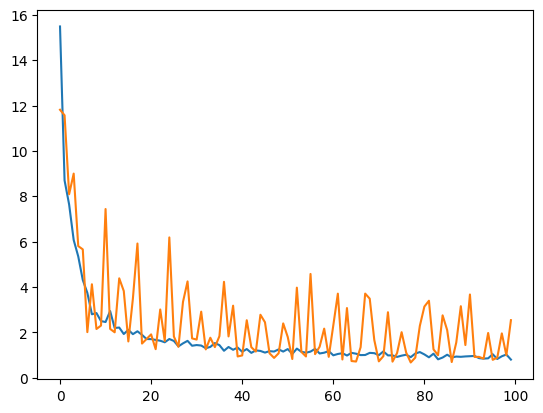

0
1
2


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1016, 40)       │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1016, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1016, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 506, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 502, 60)        │        12,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 502, 60)        │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 502, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 249, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14940)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1028)           │    15,359,348 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 19,608,325 (74.80 MB)

 Trainable params: 19,608,085 (74.80 MB)

 Non-trainable params: 240 (960.00 B)

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - MeanAbsoluteError: 27.8980 - loss: 27.8980
Epoch 1: val_loss improved from inf to 5.74305, saving model to ../models/reference/cnn_3_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - MeanAbsoluteError: 27.8678 - loss: 27.8678 - val_MeanAbsoluteError: 5.7431 - val_loss: 5.7431
Epoch 2/100
355/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 8.1768 - loss: 8.1768
Epoch 2: val_loss improved from 5.74305 to 4.00895, saving model to ../models/reference/cnn_3_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 8.1658 - loss: 8.1658 - val_MeanAbsoluteError: 4.0090 - val_loss: 4.0090
Epoch 3/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.2019 - loss: 5.2019
Epoch 3: val_loss did not improve from 4.00895
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 5.1947 - loss: 5.1947 - val_MeanAbsoluteError: 8.6869 - val_loss: 8.6869
Epoch 4/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 5.5886 - loss: 5.5886
Epoch 4: val_loss did not improve from 4.00895
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 5.5851 - loss: 5.5851 - val_MeanAbsoluteError: 6.6280 - val_loss: 6.6280
Epoch 5/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 3.7503 - loss: 3.7503
Epoch 5: val_loss did not improve from 4.00895
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 3.7495 - loss: 3.7495 - val_MeanAbsoluteError: 4.9853 - val_loss: 4.9853
Epoch 6/100
354/358 ━━━━━━━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 3.8304 - loss: 3.8304 - val_MeanAbsoluteError: 2.0199 - val_loss: 2.0199
Epoch 8/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.5763 - loss: 2.5763
Epoch 8: val_loss did not improve from 2.01987
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.5767 - loss: 2.5767 - val_MeanAbsoluteError: 2.1351 - val_loss: 2.1351
Epoch 9/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.3536 - loss: 2.3536
Epoch 9: val_loss did not improve from 2.01987
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.3533 - loss: 2.3533 - val_MeanAbsoluteError: 2.1716 - val_loss: 2.1716
Epoch 10/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.6153 - loss: 2.6153
Epoch 10: val_loss did not improve from 2.01987
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.6147 - loss: 2.6147 - val_MeanAbsoluteError: 3.4174 - val_loss: 3.4174
Epoch 11/100
354/358 ━━━━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.9030 - loss: 1.9030 - val_MeanAbsoluteError: 1.6128 - val_loss: 1.6128
Epoch 16/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.0400 - loss: 2.0400
Epoch 16: val_loss did not improve from 1.61278
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.0381 - loss: 2.0381 - val_MeanAbsoluteError: 6.8220 - val_loss: 6.8220
Epoch 17/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 2.5496 - loss: 2.5496
Epoch 17: val_loss did not improve from 1.61278
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.5384 - loss: 2.5384 - val_MeanAbsoluteError: 2.6512 - val_loss: 2.6512
Epoch 18/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.6712 - loss: 1.6712
Epoch 18: val_loss did not improve from 1.61278
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.6699 - loss: 1.6699 - val_MeanAbsoluteError: 4.2182 - val_loss: 4.2182
Epoch 19/100
358/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 2.0164 - loss: 2.0164 - val_MeanAbsoluteError: 1.3660 - val_loss: 1.3660
Epoch 21/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.7462 - loss: 1.7462
Epoch 21: val_loss did not improve from 1.36602
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.7459 - loss: 1.7459 - val_MeanAbsoluteError: 2.5885 - val_loss: 2.5885
Epoch 22/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.7238 - loss: 1.7238
Epoch 22: val_loss improved from 1.36602 to 1.27811, saving model to ../models/reference/cnn_3_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.7233 - loss: 1.7233 - val_MeanAbsoluteError: 1.2781 - val_loss: 1.2781
Epoch 23/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.4134 - loss: 1.4134
Epoch 23: val_loss did not improve from 1.27811
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.4131 - loss: 1.4131 - val_MeanAbsoluteError: 1.7040 - val_loss: 1.7040
Epoch 24/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.9142 - loss: 1.9142
Epoch 24: val_loss improved from 1.27811 to 1.08582, saving model to ../models/reference/cnn_3_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.9131 - loss: 1.9131 - val_MeanAbsoluteError: 1.0858 - val_loss: 1.0858
Epoch 25/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.7015 - loss: 1.7015
Epoch 25: val_loss did not improve from 1.08582
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.7011 - loss: 1.7011 - val_MeanAbsoluteError: 1.3479 - val_loss: 1.3479
Epoch 26/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.5429 - loss: 1.5429
Epoch 26: val_loss did not improve from 1.08582
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.5418 - loss: 1.5418 - val_MeanAbsoluteError: 1.4256 - val_loss: 1.4256
Epoch 27/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.3428 - loss: 1.3428
Epoch 27: val_loss did not improve from 1.08582
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.3427 - loss: 1.3427 - val_MeanAbsoluteError: 2.7246 - val_loss: 2.7246
Epoch 28/100
358/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.3271 - loss: 1.3271 - val_MeanAbsoluteError: 0.8785 - val_loss: 0.8785
Epoch 32/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.1030 - loss: 1.1030
Epoch 32: val_loss did not improve from 0.87855
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.1029 - loss: 1.1029 - val_MeanAbsoluteError: 1.6056 - val_loss: 1.6056
Epoch 33/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.2017 - loss: 1.2017
Epoch 33: val_loss did not improve from 0.87855
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2013 - loss: 1.2013 - val_MeanAbsoluteError: 1.5105 - val_loss: 1.5105
Epoch 34/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.3014 - loss: 1.3014
Epoch 34: val_loss did not improve from 0.87855
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.3009 - loss: 1.3009 - val_MeanAbsoluteError: 1.7223 - val_loss: 1.7223
Epoch 35/100
357/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.1327 - loss: 1.1327 - val_MeanAbsoluteError: 0.7347 - val_loss: 0.7347
Epoch 40/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.0675 - loss: 1.0675
Epoch 40: val_loss did not improve from 0.73473
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.0679 - loss: 1.0679 - val_MeanAbsoluteError: 3.3679 - val_loss: 3.3679
Epoch 41/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.4724 - loss: 1.4724
Epoch 41: val_loss did not improve from 0.73473
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.4656 - loss: 1.4656 - val_MeanAbsoluteError: 1.1487 - val_loss: 1.1487
Epoch 42/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.9565 - loss: 0.9565
Epoch 42: val_loss did not improve from 0.73473
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.9565 - loss: 0.9565 - val_MeanAbsoluteError: 0.9339 - val_loss: 0.9339
Epoch 43/100
358/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.8913 - loss: 0.8913 - val_MeanAbsoluteError: 0.7283 - val_loss: 0.7283
Epoch 46/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.9989 - loss: 0.9989
Epoch 46: val_loss did not improve from 0.72832
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.9985 - loss: 0.9985 - val_MeanAbsoluteError: 3.2477 - val_loss: 3.2477
Epoch 47/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.1295 - loss: 1.1295
Epoch 47: val_loss did not improve from 0.72832
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.1293 - loss: 1.1293 - val_MeanAbsoluteError: 1.6737 - val_loss: 1.6737
Epoch 48/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.2084 - loss: 1.2084
Epoch 48: val_loss did not improve from 0.72832
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2073 - loss: 1.2073 - val_MeanAbsoluteError: 2.8919 - val_loss: 2.8919
Epoch 49/100
357/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.9606 - loss: 0.9606 - val_MeanAbsoluteError: 0.6267 - val_loss: 0.6267
Epoch 52/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.8712 - loss: 0.8712
Epoch 52: val_loss did not improve from 0.62673
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.8711 - loss: 0.8711 - val_MeanAbsoluteError: 1.6788 - val_loss: 1.6788
Epoch 53/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.2761 - loss: 1.2761
Epoch 53: val_loss did not improve from 0.62673
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2729 - loss: 1.2729 - val_MeanAbsoluteError: 2.6983 - val_loss: 2.6983
Epoch 54/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.3957 - loss: 1.3957
Epoch 54: val_loss did not improve from 0.62673
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.3947 - loss: 1.3947 - val_MeanAbsoluteError: 0.8893 - val_loss: 0.8893
Epoch 55/100
357/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 1.0463 - loss: 1.0463 - val_MeanAbsoluteError: 0.6212 - val_loss: 0.6212
Epoch 84/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.6291 - loss: 0.6291
Epoch 84: val_loss did not improve from 0.62123
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.6293 - loss: 0.6293 - val_MeanAbsoluteError: 2.5038 - val_loss: 2.5038
Epoch 85/100
354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.8656 - loss: 0.8656
Epoch 85: val_loss did not improve from 0.62123
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.8626 - loss: 0.8626 - val_MeanAbsoluteError: 1.9442 - val_loss: 1.9442
Epoch 86/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.8656 - loss: 0.8656
Epoch 86: val_loss did not improve from 0.62123
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.8653 - loss: 0.8653 - val_MeanAbsoluteError: 1.6001 - val_loss: 1.6001
Epoch 87/100
357/358 ━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - MeanAbsoluteError: 0.7503 - loss: 0.7503 - val_MeanAbsoluteError: 0.5425 - val_loss: 0.5425
Epoch 91/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.7119 - loss: 0.7119
Epoch 91: val_loss did not improve from 0.54250
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.7117 - loss: 0.7117 - val_MeanAbsoluteError: 1.2519 - val_loss: 1.2519
Epoch 92/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 0.5782 - loss: 0.5782
Epoch 92: val_loss did not improve from 0.54250
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.5784 - loss: 0.5784 - val_MeanAbsoluteError: 2.2211 - val_loss: 2.2211
Epoch 93/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - MeanAbsoluteError: 1.0494 - loss: 1.0494
Epoch 93: val_loss did not improve from 0.54250
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.0486 - loss: 1.0486 - val_MeanAbsoluteError: 1.8504 - val_loss: 1.8504
Epoch 94/100
358/358 ━━━

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.1820 - mean_absolute_error: 3.1820


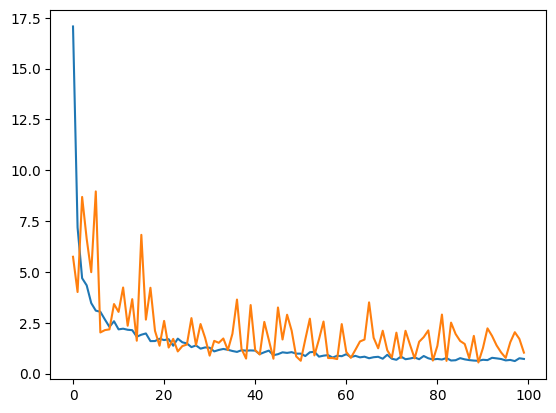

0
1
2
3


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 1016, 40)       │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1016, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 1016, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 506, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 502, 60)        │        12,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 502, 60)        │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 502, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 249, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 245, 80)        │        24,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 245, 80)        │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 245, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 121, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1028)           │     9,952,068 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1028)           │     1,057,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 1028)           │             

 Total params: 14,225,445 (54.27 MB)

 Trainable params: 14,225,045 (54.26 MB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - MeanAbsoluteError: 30.1913 - loss: 30.1913
Epoch 1: val_loss improved from inf to 7.81483, saving model to ../models/reference/cnn_4_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - MeanAbsoluteError: 30.1586 - loss: 30.1586 - val_MeanAbsoluteError: 7.8148 - val_loss: 7.8148
Epoch 2/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 7.9319 - loss: 7.9319
Epoch 2: val_loss improved from 7.81483 to 4.21564, saving model to ../models/reference/cnn_4_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 7.9274 - loss: 7.9274 - val_MeanAbsoluteError: 4.2156 - val_loss: 4.2156
Epoch 3/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 4.5133 - loss: 4.5133
Epoch 3: val_loss improved from 4.21564 to 3.07789, saving model to ../models/reference/cnn_4_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 4.5089 - loss: 4.5089 - val_MeanAbsoluteError: 3.0779 - val_loss: 3.0779
Epoch 4/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.7630 - loss: 3.7630
Epoch 4: val_loss improved from 3.07789 to 2.61821, saving model to ../models/reference/cnn_4_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 3.7577 - loss: 3.7577 - val_MeanAbsoluteError: 2.6182 - val_loss: 2.6182
Epoch 5/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.0334 - loss: 3.0334
Epoch 5: val_loss did not improve from 2.61821
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 3.0354 - loss: 3.0354 - val_MeanAbsoluteError: 6.0413 - val_loss: 6.0413
Epoch 6/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.2320 - loss: 3.2320
Epoch 6: val_loss did not improve from 2.61821
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 3.2241 - loss: 3.2241 - val_MeanAbsoluteError: 4.2124 - val_loss: 4.2124
Epoch 7/100
356/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.9828 - loss: 2.9828
Epoch 7: val_loss did not improve from 2.61821
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.9808 - loss: 2.9808 - val_MeanAbsoluteError: 4.0871 - val_loss: 4.0871
Epoch 8/100
351/358 ━━━━━━━━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.5698 - loss: 2.5698 - val_MeanAbsoluteError: 2.1544 - val_loss: 2.1544
Epoch 9/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.4698 - loss: 2.4698
Epoch 9: val_loss did not improve from 2.15444
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.4702 - loss: 2.4702 - val_MeanAbsoluteError: 3.4069 - val_loss: 3.4069
Epoch 10/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.3969 - loss: 2.3969
Epoch 10: val_loss did not improve from 2.15444
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.3965 - loss: 2.3965 - val_MeanAbsoluteError: 3.1161 - val_loss: 3.1161
Epoch 11/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.6046 - loss: 2.6046
Epoch 11: val_loss did not improve from 2.15444
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.5954 - loss: 2.5954 - val_MeanAbsoluteError: 3.9909 - val_loss: 3.9909
Epoch 12/100
351/358 ━━━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.2462 - loss: 2.2462 - val_MeanAbsoluteError: 1.7739 - val_loss: 1.7739
Epoch 13/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.0053 - loss: 2.0053
Epoch 13: val_loss did not improve from 1.77387
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.0057 - loss: 2.0057 - val_MeanAbsoluteError: 2.2931 - val_loss: 2.2931
Epoch 14/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.8910 - loss: 1.8910
Epoch 14: val_loss did not improve from 1.77387
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.8891 - loss: 1.8891 - val_MeanAbsoluteError: 1.8129 - val_loss: 1.8129
Epoch 15/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.9838 - loss: 1.9838
Epoch 15: val_loss did not improve from 1.77387
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.9830 - loss: 1.9830 - val_MeanAbsoluteError: 4.0837 - val_loss: 4.0837
Epoch 16/100
351/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 2.2906 - loss: 2.2906 - val_MeanAbsoluteError: 1.6437 - val_loss: 1.6437
Epoch 17/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.7461 - loss: 1.7461
Epoch 17: val_loss did not improve from 1.64368
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.7460 - loss: 1.7460 - val_MeanAbsoluteError: 4.8529 - val_loss: 4.8529
Epoch 18/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.2804 - loss: 2.2804
Epoch 18: val_loss did not improve from 1.64368
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.2704 - loss: 2.2704 - val_MeanAbsoluteError: 3.9009 - val_loss: 3.9009
Epoch 19/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.7451 - loss: 1.7451
Epoch 19: val_loss improved from 1.64368 to 1.25644, saving model to ../models/reference/cnn_4_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.7431 - loss: 1.7431 - val_MeanAbsoluteError: 1.2564 - val_loss: 1.2564
Epoch 20/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.5964 - loss: 1.5964
Epoch 20: val_loss did not improve from 1.25644
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.5955 - loss: 1.5955 - val_MeanAbsoluteError: 4.0021 - val_loss: 4.0021
Epoch 21/100
357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.2341 - loss: 2.2341
Epoch 21: val_loss did not improve from 1.25644
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.2312 - loss: 2.2312 - val_MeanAbsoluteError: 3.6510 - val_loss: 3.6510
Epoch 22/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.1509 - loss: 2.1509
Epoch 22: val_loss did not improve from 1.25644
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.1415 - loss: 2.1415 - val_MeanAbsoluteError: 4.0899 - val_loss: 4.0899
Epoch 23/100
351/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.1686 - loss: 1.1686 - val_MeanAbsoluteError: 1.2232 - val_loss: 1.2232
Epoch 29/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2592 - loss: 1.2592
Epoch 29: val_loss did not improve from 1.22321
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2587 - loss: 1.2587 - val_MeanAbsoluteError: 2.1237 - val_loss: 2.1237
Epoch 30/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.5479 - loss: 1.5479
Epoch 30: val_loss did not improve from 1.22321
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.5418 - loss: 1.5418 - val_MeanAbsoluteError: 2.3598 - val_loss: 2.3598
Epoch 31/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.3664 - loss: 1.3664
Epoch 31: val_loss did not improve from 1.22321
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.3645 - loss: 1.3645 - val_MeanAbsoluteError: 3.7391 - val_loss: 3.7391
Epoch 32/100
351/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.2908 - loss: 1.2908 - val_MeanAbsoluteError: 0.9132 - val_loss: 0.9132
Epoch 34/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.0406 - loss: 1.0406
Epoch 34: val_loss did not improve from 0.91318
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.0409 - loss: 1.0409 - val_MeanAbsoluteError: 3.1661 - val_loss: 3.1661
Epoch 35/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.6096 - loss: 1.6096
Epoch 35: val_loss did not improve from 0.91318
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.6018 - loss: 1.6018 - val_MeanAbsoluteError: 1.7000 - val_loss: 1.7000
Epoch 36/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2138 - loss: 1.2138
Epoch 36: val_loss improved from 0.91318 to 0.68627, saving model to ../models/reference/cnn_4_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.2119 - loss: 1.2119 - val_MeanAbsoluteError: 0.6863 - val_loss: 0.6863
Epoch 37/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.3751 - loss: 1.3751
Epoch 37: val_loss did not improve from 0.68627
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.3722 - loss: 1.3722 - val_MeanAbsoluteError: 1.0825 - val_loss: 1.0825
Epoch 38/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2304 - loss: 1.2304
Epoch 38: val_loss did not improve from 0.68627
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2275 - loss: 1.2275 - val_MeanAbsoluteError: 0.9294 - val_loss: 0.9294
Epoch 39/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.1706 - loss: 1.1706
Epoch 39: val_loss improved from 0.68627 to 0.63261, saving model to ../models/reference/cnn_4_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 1.1687 - loss: 1.1687 - val_MeanAbsoluteError: 0.6326 - val_loss: 0.6326
Epoch 40/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.9781 - loss: 0.9781
Epoch 40: val_loss did not improve from 0.63261
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.9787 - loss: 0.9787 - val_MeanAbsoluteError: 2.1144 - val_loss: 2.1144
Epoch 41/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2199 - loss: 1.2199
Epoch 41: val_loss did not improve from 0.63261
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2161 - loss: 1.2161 - val_MeanAbsoluteError: 2.4804 - val_loss: 2.4804
Epoch 42/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2429 - loss: 1.2429
Epoch 42: val_loss did not improve from 0.63261
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2381 - loss: 1.2381 - val_MeanAbsoluteError: 0.7281 - val_loss: 0.7281
Epoch 43/100
351/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - MeanAbsoluteError: 0.5880 - loss: 0.5880 - val_MeanAbsoluteError: 0.5033 - val_loss: 0.5033
Epoch 93/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.7697 - loss: 0.7697
Epoch 93: val_loss did not improve from 0.50332
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.7700 - loss: 0.7700 - val_MeanAbsoluteError: 2.0626 - val_loss: 2.0626
Epoch 94/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.7818 - loss: 0.7818
Epoch 94: val_loss did not improve from 0.50332
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.7787 - loss: 0.7787 - val_MeanAbsoluteError: 1.3741 - val_loss: 1.3741
Epoch 95/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.7750 - loss: 0.7750
Epoch 95: val_loss did not improve from 0.50332
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.7721 - loss: 0.7721 - val_MeanAbsoluteError: 1.8662 - val_loss: 1.8662
Epoch 96/100
353/358 ━━━━

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.6709 - mean_absolute_error: 6.6709


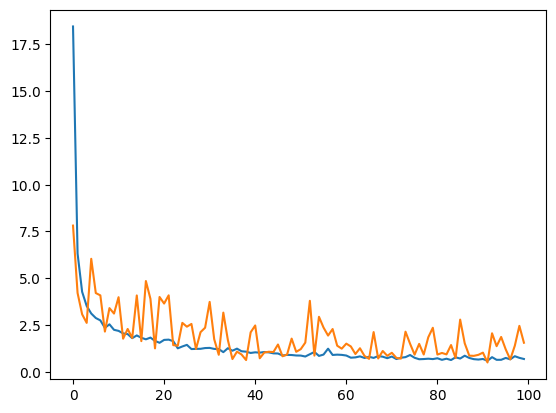

0
1
2
3
4


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2048, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 2044, 20)       │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2044, 20)       │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 2044, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 1020, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 1016, 40)       │         4,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1016, 40)       │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 1016, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 506, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 502, 60)        │        12,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 502, 60)        │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 502, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 249, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 245, 80)        │        24,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 245, 80)        │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 245, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 121, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 117, 100)       │        40,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 117, 100)       │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 117, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 57, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5700)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,174,505 (38.81 MB)

 Trainable params: 10,173,905 (38.81 MB)

 Non-trainable params: 600 (2.34 KB)

Epoch 1/100
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - MeanAbsoluteError: 31.6110 - loss: 31.6110
Epoch 1: val_loss improved from inf to 8.73273, saving model to ../models/reference/cnn_5_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - MeanAbsoluteError: 31.5779 - loss: 31.5779 - val_MeanAbsoluteError: 8.7327 - val_loss: 8.7327
Epoch 2/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 8.3403 - loss: 8.3403
Epoch 2: val_loss improved from 8.73273 to 4.81782, saving model to ../models/reference/cnn_5_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 8.3217 - loss: 8.3217 - val_MeanAbsoluteError: 4.8178 - val_loss: 4.8178
Epoch 3/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 5.3469 - loss: 5.3469
Epoch 3: val_loss did not improve from 4.81782
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 5.3399 - loss: 5.3399 - val_MeanAbsoluteError: 4.9214 - val_loss: 4.9214
Epoch 4/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.8160 - loss: 3.8160
Epoch 4: val_loss improved from 4.81782 to 3.19471, saving model to ../models/reference/cnn_5_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 3.8140 - loss: 3.8140 - val_MeanAbsoluteError: 3.1947 - val_loss: 3.1947
Epoch 5/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.1960 - loss: 3.1960
Epoch 5: val_loss did not improve from 3.19471
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 3.1943 - loss: 3.1943 - val_MeanAbsoluteError: 4.1270 - val_loss: 4.1270
Epoch 6/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.5680 - loss: 3.5680
Epoch 6: val_loss did not improve from 3.19471
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 3.5590 - loss: 3.5590 - val_MeanAbsoluteError: 4.4351 - val_loss: 4.4351
Epoch 7/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 3.4086 - loss: 3.4086
Epoch 7: val_loss improved from 3.19471 to 2.81018, saving model to ../models/reference/cnn_5_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 3.4013 - loss: 3.4013 - val_MeanAbsoluteError: 2.8102 - val_loss: 2.8102
Epoch 8/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.6503 - loss: 2.6503
Epoch 8: val_loss improved from 2.81018 to 2.69060, saving model to ../models/reference/cnn_5_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.6478 - loss: 2.6478 - val_MeanAbsoluteError: 2.6906 - val_loss: 2.6906
Epoch 9/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.3596 - loss: 2.3596
Epoch 9: val_loss did not improve from 2.69060
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 2.3599 - loss: 2.3599 - val_MeanAbsoluteError: 3.3767 - val_loss: 3.3767
Epoch 10/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.3184 - loss: 2.3184
Epoch 10: val_loss did not improve from 2.69060
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 2.3163 - loss: 2.3163 - val_MeanAbsoluteError: 4.0599 - val_loss: 4.0599
Epoch 11/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.4013 - loss: 2.4013
Epoch 11: val_loss improved from 2.69060 to 1.60096, saving model to ../models/reference/cnn_5_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 2.3963 - loss: 2.3963 - val_MeanAbsoluteError: 1.6010 - val_loss: 1.6010
Epoch 12/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.1107 - loss: 2.1107
Epoch 12: val_loss did not improve from 1.60096
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 2.1110 - loss: 2.1110 - val_MeanAbsoluteError: 1.9502 - val_loss: 1.9502
Epoch 13/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.9846 - loss: 1.9846
Epoch 13: val_loss improved from 1.60096 to 1.38600, saving model to ../models/reference/cnn_5_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.9823 - loss: 1.9823 - val_MeanAbsoluteError: 1.3860 - val_loss: 1.3860
Epoch 14/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.7477 - loss: 1.7477
Epoch 14: val_loss did not improve from 1.38600
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.7498 - loss: 1.7498 - val_MeanAbsoluteError: 3.5981 - val_loss: 3.5981
Epoch 15/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 2.1658 - loss: 2.1658
Epoch 15: val_loss did not improve from 1.38600
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 2.1626 - loss: 2.1626 - val_MeanAbsoluteError: 2.0641 - val_loss: 2.0641
Epoch 16/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.8367 - loss: 1.8367
Epoch 16: val_loss did not improve from 1.38600
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.8361 - loss: 1.8361 - val_MeanAbsoluteError: 1.5409 - val_loss: 1.5409
Epoch 17/100
353/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.5481 - loss: 1.5481 - val_MeanAbsoluteError: 1.2789 - val_loss: 1.2789
Epoch 19/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.6414 - loss: 1.6414
Epoch 19: val_loss did not improve from 1.27890
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.6418 - loss: 1.6418 - val_MeanAbsoluteError: 1.3791 - val_loss: 1.3791
Epoch 20/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.3291 - loss: 1.3291
Epoch 20: val_loss did not improve from 1.27890
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.3285 - loss: 1.3285 - val_MeanAbsoluteError: 2.8256 - val_loss: 2.8256
Epoch 21/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.6141 - loss: 1.6141
Epoch 21: val_loss did not improve from 1.27890
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.6123 - loss: 1.6123 - val_MeanAbsoluteError: 3.6159 - val_loss: 3.6159
Epoch 22/100
353/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.1873 - loss: 1.1873 - val_MeanAbsoluteError: 1.1469 - val_loss: 1.1469
Epoch 25/100
351/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.3027 - loss: 1.3027
Epoch 25: val_loss did not improve from 1.14690
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.3005 - loss: 1.3005 - val_MeanAbsoluteError: 3.1549 - val_loss: 3.1549
Epoch 26/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.8932 - loss: 1.8932
Epoch 26: val_loss did not improve from 1.14690
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.8865 - loss: 1.8865 - val_MeanAbsoluteError: 1.8344 - val_loss: 1.8344
Epoch 27/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2661 - loss: 1.2661
Epoch 27: val_loss did not improve from 1.14690
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.2653 - loss: 1.2653 - val_MeanAbsoluteError: 2.7172 - val_loss: 2.7172
Epoch 28/100
353/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.6971 - loss: 1.6971 - val_MeanAbsoluteError: 1.0666 - val_loss: 1.0666
Epoch 30/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.1907 - loss: 1.1907
Epoch 30: val_loss did not improve from 1.06662
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.1907 - loss: 1.1907 - val_MeanAbsoluteError: 3.8900 - val_loss: 3.8900
Epoch 31/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.8135 - loss: 1.8135
Epoch 31: val_loss did not improve from 1.06662
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.8063 - loss: 1.8063 - val_MeanAbsoluteError: 2.2331 - val_loss: 2.2331
Epoch 32/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2180 - loss: 1.2180
Epoch 32: val_loss did not improve from 1.06662
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.2169 - loss: 1.2169 - val_MeanAbsoluteError: 1.5071 - val_loss: 1.5071
Epoch 33/100
353/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.4253 - loss: 1.4253 - val_MeanAbsoluteError: 0.9345 - val_loss: 0.9345
Epoch 43/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.0108 - loss: 1.0108
Epoch 43: val_loss did not improve from 0.93453
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.0114 - loss: 1.0114 - val_MeanAbsoluteError: 4.0572 - val_loss: 4.0572
Epoch 44/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.5186 - loss: 1.5186
Epoch 44: val_loss did not improve from 0.93453
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 1.5096 - loss: 1.5096 - val_MeanAbsoluteError: 1.6359 - val_loss: 1.6359
Epoch 45/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 1.2857 - loss: 1.2857
Epoch 45: val_loss improved from 0.93453 to 0.70993, saving model to ../models/reference/cnn_5_layers.h5


358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.2820 - loss: 1.2820 - val_MeanAbsoluteError: 0.7099 - val_loss: 0.7099
Epoch 46/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.9377 - loss: 0.9377
Epoch 46: val_loss did not improve from 0.70993
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.9379 - loss: 0.9379 - val_MeanAbsoluteError: 1.0211 - val_loss: 1.0211
Epoch 47/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.9532 - loss: 0.9532
Epoch 47: val_loss did not improve from 0.70993
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.9524 - loss: 0.9524 - val_MeanAbsoluteError: 0.9663 - val_loss: 0.9663
Epoch 48/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.9029 - loss: 0.9029
Epoch 48: val_loss did not improve from 0.70993
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.9019 - loss: 0.9019 - val_MeanAbsoluteError: 1.1771 - val_loss: 1.1771
Epoch 49/100
352/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 1.0361 - loss: 1.0361 - val_MeanAbsoluteError: 0.5725 - val_loss: 0.5725
Epoch 56/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.8654 - loss: 0.8654
Epoch 56: val_loss did not improve from 0.57246
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.8661 - loss: 0.8661 - val_MeanAbsoluteError: 1.9636 - val_loss: 1.9636
Epoch 57/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.8384 - loss: 0.8384
Epoch 57: val_loss did not improve from 0.57246
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.8380 - loss: 0.8380 - val_MeanAbsoluteError: 1.0700 - val_loss: 1.0700
Epoch 58/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.8907 - loss: 0.8907
Epoch 58: val_loss did not improve from 0.57246
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.8889 - loss: 0.8889 - val_MeanAbsoluteError: 0.9254 - val_loss: 0.9254
Epoch 59/100
353/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.7905 - loss: 0.7905 - val_MeanAbsoluteError: 0.4825 - val_loss: 0.4825
Epoch 64/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.6583 - loss: 0.6583
Epoch 64: val_loss did not improve from 0.48254
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.6588 - loss: 0.6588 - val_MeanAbsoluteError: 1.0209 - val_loss: 1.0209
Epoch 65/100
352/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.8165 - loss: 0.8165
Epoch 65: val_loss did not improve from 0.48254
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.8172 - loss: 0.8172 - val_MeanAbsoluteError: 1.2569 - val_loss: 1.2569
Epoch 66/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.8414 - loss: 0.8414
Epoch 66: val_loss did not improve from 0.48254
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.8399 - loss: 0.8399 - val_MeanAbsoluteError: 0.7047 - val_loss: 0.7047
Epoch 67/100
351/358 ━━━━

358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - MeanAbsoluteError: 0.6539 - loss: 0.6539 - val_MeanAbsoluteError: 0.3735 - val_loss: 0.3735
Epoch 82/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.6761 - loss: 0.6761
Epoch 82: val_loss did not improve from 0.37350
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.6765 - loss: 0.6765 - val_MeanAbsoluteError: 0.5482 - val_loss: 0.5482
Epoch 83/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.7416 - loss: 0.7416
Epoch 83: val_loss did not improve from 0.37350
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.7410 - loss: 0.7410 - val_MeanAbsoluteError: 0.8045 - val_loss: 0.8045
Epoch 84/100
353/358 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - MeanAbsoluteError: 0.7194 - loss: 0.7194
Epoch 84: val_loss did not improve from 0.37350
358/358 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - MeanAbsoluteError: 0.7190 - loss: 0.7190 - val_MeanAbsoluteError: 0.5793 - val_loss: 0.5793
Epoch 85/100
353/358 ━━━━

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.0325 - mean_absolute_error: 6.0325


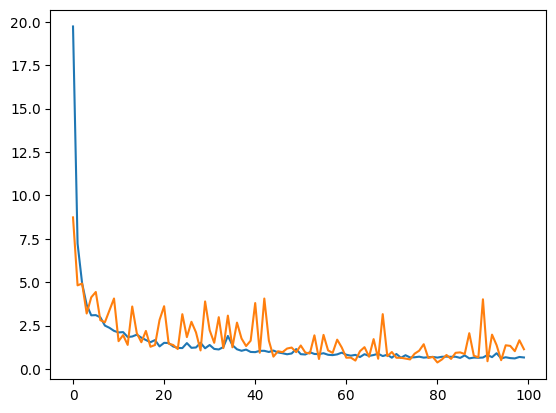

In [47]:
if not use_reference_models:
    for i in range(1,nMaxConvLayers+1):
        train_models(i)

#### Evaluation

In [49]:
2X_val.shape

(6344, 2048)

In [50]:
X_val_1 = X_val[:len(y0_val),:]
X_val_2 = X_val[len(y0_val):len(y0_val)+len(y2_val),:]
X_val_3 = X_val[len(y0_val)+len(y2_val):len(y0_val)+len(y2_val)+
                len(y3_val),:]
X_val_4 = X_val[len(y0_val)+len(y2_val)+len(y3_val):len(y0_val)+
                len(y2_val)+len(y3_val)+len(y4_val),:]

In [52]:
accuracies = []
accuracies_all = []
for layer_n in range(1,nMaxConvLayers+1):

    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    print(f"Resultados {layer_n} Conv Layers ")
    val_acc_1 = model_i.evaluate(X_val_1, y0_val)[1]
    val_acc_2 = model_i.evaluate(X_val_2, y2_val)[1]
    val_acc_3 = model_i.evaluate(X_val_3, y3_val)[1]
    val_acc_4 = model_i.evaluate(X_val_4, y4_val)[1]
    #val_acc_5 = model_i.evaluate(X_val_5, y4_val)[1]
    val_acc_all = model_i.evaluate(X_val, y_val)[1]
    accuracies_layer_i = [val_acc_1, val_acc_2, val_acc_3, val_acc_4]
    accuracies.append(accuracies_layer_i)
    accuracies_all.append(val_acc_all)

accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

Resultados 1 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0405 - mean_absolute_error: 0.0405
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.2266 - mean_absolute_error: 5.2266
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.9518 - mean_absolute_error: 3.9518
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.6073 - mean_absolute_error: 3.6073
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8999 - mean_absolute_error: 1.8999


Resultados 2 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0011
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2712 - mean_absolute_error: 4.2712
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9349 - mean_absolute_error: 2.9349
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8077 - mean_absolute_error: 1.8077
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5502 - mean_absolute_error: 1.5502


Resultados 3 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0018
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.0435 - mean_absolute_error: 14.0435
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.2976 - mean_absolute_error: 3.2976
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3640 - mean_absolute_error: 1.3640
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.1820 - mean_absolute_error: 3.1820


Resultados 4 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0043 - mean_absolute_error: 0.0043
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.2300 - mean_absolute_error: 18.2300
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.6930 - mean_absolute_error: 6.6930
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0329 - mean_absolute_error: 1.0329
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.6709 - mean_absolute_error: 6.6709


Resultados 5 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.1010e-04 - mean_absolute_error: 7.1010e-04
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.0473 - mean_absolute_error: 14.0473
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.9227 - mean_absolute_error: 7.9227
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0912 - mean_absolute_error: 1.0912
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0325 - mean_absolute_error: 6.0325


In [53]:
accuracies_all

array([3.21932364, 2.46225405, 3.9153204 , 8.33192825, 8.19437313])

In [54]:
accuracies = np.array(accuracies)
accuracies_all = np.array(accuracies_all)

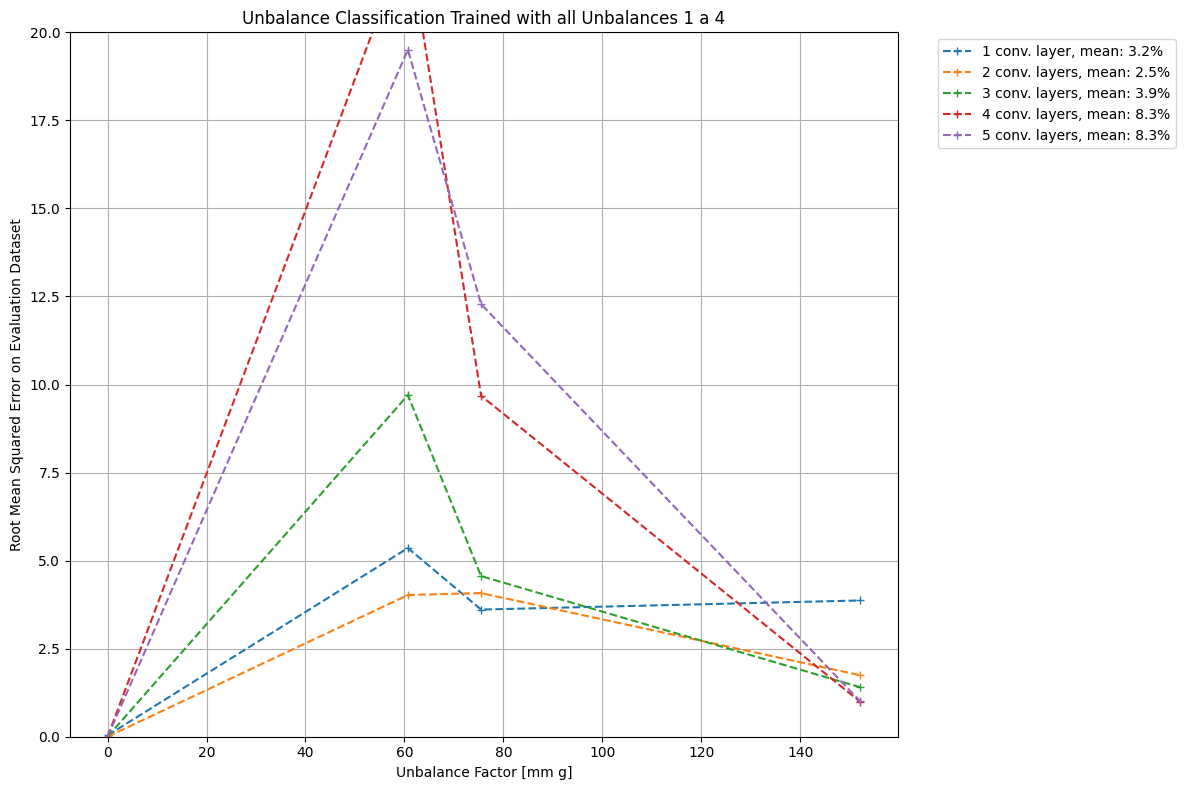

In [55]:
fig=plt.figure(figsize=(12,8))
ax1=plt.subplot(111, title = "Unbalance Classification Trained with all Unbalances 1 a 4")
unbalances = np.array([0, 6.07e-5,7.55e-5,1.521e-4])
ax1.plot(1e6*unbalances, accuracies[0,:], label=f"1 conv. layer, mean: {accuracies_all[0]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[1,:], label=f"2 conv. layers, mean: {accuracies_all[1]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[2,:], label=f"3 conv. layers, mean: {accuracies_all[2]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[3,:], label=f"4 conv. layers, mean: {accuracies_all[3]:.1f}%", marker="+", ls="--")
ax1.plot(1e6*unbalances, accuracies[4,:], label=f"5 conv. layers, mean: {accuracies_all[3]:.1f}%", marker="+", ls="--")
plt.ylabel("Root Mean Squared Error on Evaluation Dataset")
plt.xlabel("Unbalance Factor [mm g]")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylim([0, 20])
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
predictions_by_class = []
predictions_all = []
for layer_n in range(1,nMaxConvLayers+1):

    filepath = f"{model_path}/cnn_{layer_n}_layers.h5"
    model_i = load_model(filepath)
    print(f"Resultados {layer_n} Conv Layers ")
    y_pred_1 = model_i.predict(X_val_1)
    y_pred_2 = model_i.predict(X_val_2)
    y_pred_3 = model_i.predict(X_val_3)
    y_pred_4 = model_i.predict(X_val_4)
    #y_pred_5 = model_i.predict(X_val_5)
    y_pred_all = model_i.predict(X_val)
    predictions_layer_i = [ y_pred_1,  y_pred_2,  y_pred_3,  y_pred_4]
    predictions_by_class.append(predictions_layer_i)
    predictions_all.append(y_pred_all)

#predictions_by_class = np.array(predictions_by_class)
#predictions_all = np.array(predictions_all)

Resultados 1 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Resultados 2 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Resultados 3 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Resultados 4 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Resultados 5 Conv Layers 
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [57]:
def imprime_resultado(lista_de_previsoes, qde_camadas, classe):
  baselines = [0.0, 60.7, 75.5, 152,1]
  plt.plot(lista_de_previsoes[qde_camadas-1][classe])
  x_max = len(lista_de_previsoes[qde_camadas-1][classe])
  plt.hlines(y=baselines[classe], xmin=0, xmax=x_max, colors=['r'], linestyles=['--'])
  plt.ylim([-20,180])
  plt.show()
  return

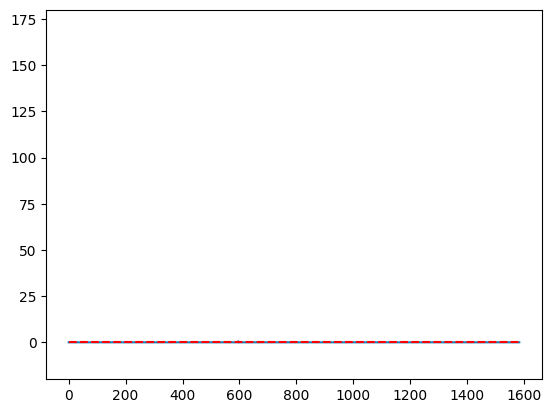

In [58]:
imprime_resultado(predictions_by_class, 2, 0)

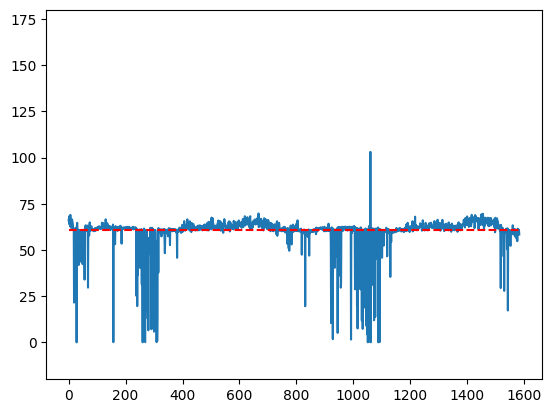

In [59]:
imprime_resultado(predictions_by_class, 2, 1)

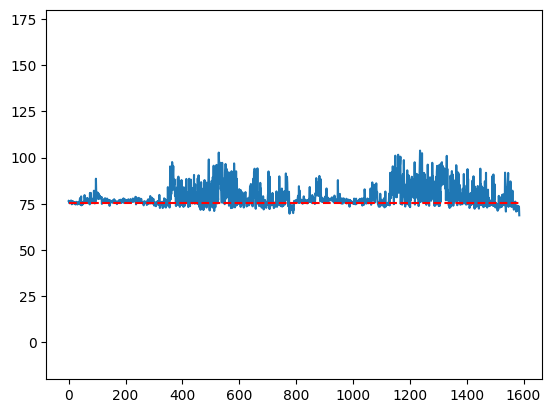

In [60]:
imprime_resultado(predictions_by_class, 2, 2)

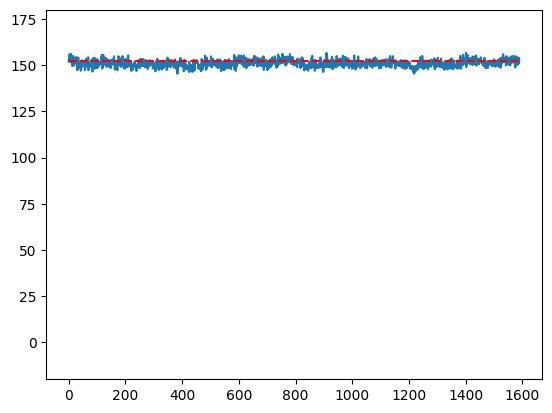

In [61]:
imprime_resultado(predictions_by_class, 2, 3)

In [65]:
def imprime_todos_resultados(lista_de_previsoes, qde_camadas):
  baselines = [0.0, 60.7, 75.5, 152,1]
  for classe in range(4):
    plt.plot(lista_de_previsoes[qde_camadas-1][classe])
    x_max = len(lista_de_previsoes[qde_camadas-1][classe])
    plt.hlines(y=baselines[classe], xmin=0, xmax=x_max, colors=['k'], linestyles=['--'])
    plt.ylim([-20,180])
  plt.show()
  return

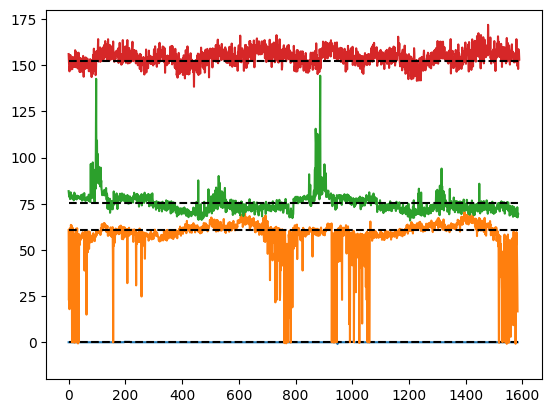

In [66]:
imprime_todos_resultados(predictions_by_class, qde_camadas = 1)

**SEABORN**

**Histogramas**

In [67]:
len(y_pred_1), len(y_pred_2), len(y_pred_3), len(y_pred_4)

(1584, 1584, 1586, 1590)

In [68]:
previsoes = np.concatenate([y_pred_1[:1584], y_pred_2[:1584], y_pred_3[:1584], y_pred_4[:1584]], axis=1)


In [69]:
previsoes.shape

(1584, 4)

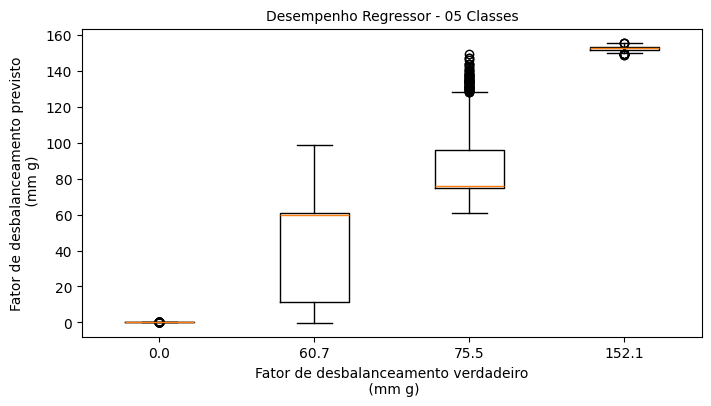

In [70]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(8,4))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(previsoes,  vert = 0, patch_artist = False)


# Adicionando Título ao gráfico
plt.title("Desempenho Regressor - 05 Classes", loc="center", fontsize=10)
plt.xlabel("Fator de desbalanceamento verdadeiro\n (mm g)")
ticks = [1,2,3,4]  # Positions for the ticks
labels = [0.0, 60.7, 75.5, 152.1]  # Labels for the ticks
plt.xticks(ticks, labels)  # Set the ticks and labels
plt.ylabel("Fator de desbalanceamento previsto\n (mm g)")

plt.show()

**Distribuições**

In [71]:
df_predict = pd.DataFrame(previsoes)

In [72]:
df_predict.head()

,0,1,2,3
0,0.000393,60.226093,75.464798,150.402405
1,0.000897,60.594788,75.382713,150.786469
2,0.000932,66.630287,75.217079,150.632172
3,0.000828,60.668682,75.345985,150.328339
4,0.000825,60.544037,75.382774,150.183823


In [73]:
df_predict.columns=['FDesb: 0,0','FDesb: 60,7','FDesb: 75,5','FDesb: 152,1']

In [74]:
df_predict.head()

,"FDesb: 0,0","FDesb: 60,7","FDesb: 75,5","FDesb: 152,1"
0,0.000393,60.226093,75.464798,150.402405
1,0.000897,60.594788,75.382713,150.786469
2,0.000932,66.630287,75.217079,150.632172
3,0.000828,60.668682,75.345985,150.328339
4,0.000825,60.544037,75.382774,150.183823


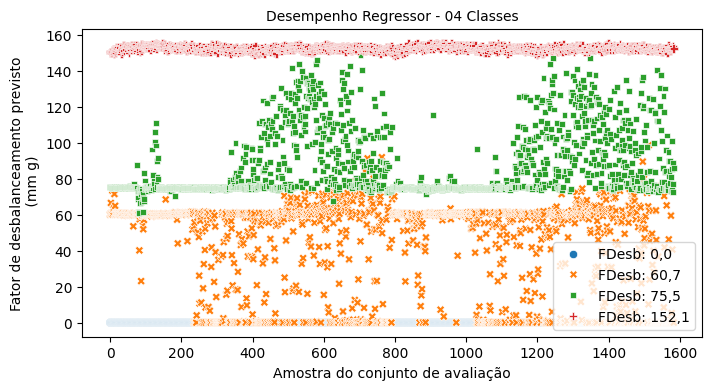

In [75]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(8,4))
plt.title("Desempenho Regressor - 04 Classes", loc="center", fontsize=10)
plt.xlabel("Amostra do conjunto de avaliação")
ax = sn.scatterplot(data=df_predict)#, marker="+")
sn.move_legend(ax, "lower right")#, bbox_to_anchor=(1, 1))
plt.ylabel("Fator de desbalanceamento previsto\n (mm g)")
plt.show()